Notebook

- Split data into train, validate, and test.
- Encode categorical columns using a one hot encoder (pd.get_dummies).
- Handles missing values.
- Scaling

Encapsulate your work in a wrangle_mall.py python module.

In [1]:
#basics
import numpy as np
import pandas as pd
import os


#viz
import matplotlib.pyplot as plt

#Data prep tools
from sklearn.model_selection import train_test_split
from itertools import filterfalse

#env
from env import host, username, password, get_db_url

##### Acquire Data

In [2]:
#sql query to use
sql = """
SELECT * FROM customers;
"""

In [3]:
#get data
df = pd.read_sql(sql,get_db_url('mall_customers'))
#general info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     200 non-null    int64 
 1   gender          200 non-null    object
 2   age             200 non-null    int64 
 3   annual_income   200 non-null    int64 
 4   spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


##### Summarize Data

In [4]:
#describe
df.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
annual_income,200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
spending_score,200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


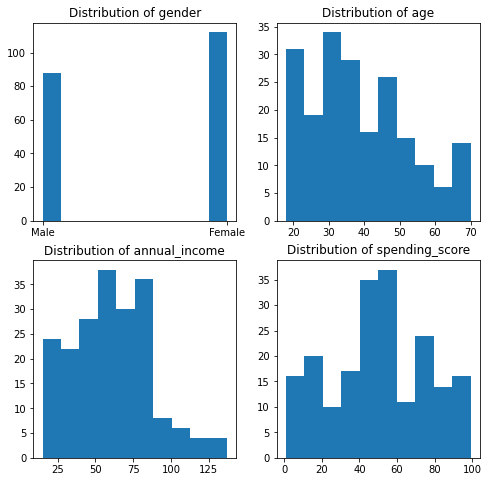

In [5]:
plt.figure(figsize=(8,8))
ct=0
for c in df.columns[1:]:
    ct+=1
    plt.subplot(2,2,ct)
    plt.hist(df[c])
    plt.title(f'Distribution of {c}')

- spending score: 1 - 99, normal with gaps around suspected IQR
- annual income: 15 to 137 >> seems like it may represent thousands
  - annual income is normalish
- age b/w 20 and 70, more b/w 20 and 50


##### detect outliers using IQR

Function options:
- Take in whole dataframe
- All for a column to ignore parameter
  - EX: this has customer_id which is a PK.  May want to keep it, but needs to be ignored.
- Columns to find IQR for:
  - in case there are some 
- Want function to either:
  - Return informational dataframe with upper and lower bounds per column (infoonly)
  - Return a trimmed dataframe - and maybe another dataframe with what was done
  - Return a dataframe with new columns that identify if a row is an outlier
  
  
Better: Create a function that finds outliers and another that handles them

# PICKUP HERE
WORKING ON IQR OUTLIER FUNCTIONS.  NEED TO FIGURE OUT HOW TO FILTER OUT COLUMNS THAT ONLY CONTAIN ZEROS AND ONES.
CONSIDER FILTERFALSE (probably won't work)
CONSIDER LIST COMPREHENSION ( https://stackoverflow.com/questions/1207406/how-to-remove-items-from-a-list-while-iterating - not sure if index counts as list)

In [6]:
# def only_0_or_1(ser):
#     """
#     Takes in a pandas series, returns True if it only contains zeros and ones.
#     """
#     return ser.isin([0,1]).all()


###IMPROVMENTS:
# 1) Currently only takes a list for include/exclude. Handle either single string input that is column name or list
# 2) if a numeric column only contains 0s and 1s, assume it to be boolean
# 3) If number of unique values is < than a certain number: 
#.     This will help identify if a column is really a category. Ruminate on this more
def get_iqr_outlier_bounds(df,include=None,exclude=None):
    """
    Returns dataframe with list of columns and the upper and lower bounds using the IQR method:
        LB = Q1 - 1.5 * IQR
        UB = Q3 + 1.5 * IQR
    If no columns passed to include or exclude, it defaults to finding outliers for all columns.
    Function will ignore non-numeric columns. FUTURE: Columns that contain only 0s and 1s.
    
    Returns: Pandas Dataframe 
    Parameters:
           df: dataframe in which to find outliers
      include: list of columns to find outliers for
       excude: list of columns to NOT find outliers for.  Ignored if 'include'is set.   
    
    C88
    """
    #Get Column List
    #if include and exclude are None
    if not include and not exclude:
        columns = df.columns #returns index - iterable
    elif include:
        columns = include
    else: columns = exclude
    
    #Only pull out numeric columns
    columns = df[columns].select_dtypes(include='number')
#     #TO DO: check if only 0s and 1s
#     for c in columns:
#         #if series contains only zeros and ones
#         if df[c].isin([0,1]).all():
    
    #create df for bounds
    bounds = pd.DataFrame()
    #for each column, 
    for col in columns:
        #find bounds
        q1, q3 = df[col].quantile([.25,.75])
        iqr = q3 - q1
        lb = q1 - (1.5 * iqr)
        ub = q3 + (1.5 * iqr)
        #put info in df
        bounds.loc['lb',col] = lb
        bounds.loc['ub',col] = ub
    return bounds

def trim_iqr_outliers(df,bounds):
    """
    Takes in the dataset dataframe, and dataframe of the bounds for each column to be trimmed.
    Returns: Trimmed dataframe
    """
    #loop over columns to work on
    for col in bounds.columns:
        #for each col, grab the outliers
        lb = bounds.loc['lb',col]
        ub = bounds.loc['ub',col]
        #create smaller df of only rows where column is in bounds
        df = df[(df[col] >= lb) & (df[col]<=ub)]
    return df

def calc_outliers(x,lb,ub):
    #if not an outlier, set to zero
    if lb <= x <= ub: return 0
    elif x < lb: return x-lb
    else: return x-ub

def add_outlier_columns(df,bounds):
    #loop over columns in bounds
    for col in bounds.columns:
        #new column name
        col_name = col + '_outlier'
        #for each column, apply the outlier calculation and store to new column
        df[col_name] = df[col].apply(calc_outliers,args=(bounds.loc['lb',col],bounds.loc['ub',col]))
    return df

##TIME PERMITTING
# Investigate why python is updating my dataframe external to the function
# needed to use df = old_df.copy() to prevent this
def handle_iqr_outliers(old_df,trim=False,include=None,exclude=None):
    """
    Takes in a dataframe and either trims outliers or creates column identifying outliers. 
    
    Outputs: None
    Returns: Pandas Dataframe
    Parameters:
                   df: dataframe in which to find outliers
                 trim: If True, will trim out any rows that contain any outliers.  
                        If False, creates new columns to indicate if row is an outlier or not.
                        Default: False
      include/exclude: list of columns to include or exclude for this function.  
                       Default is all, exclude will be ignored if include is provided.
    """    
    df= old_df.copy()    
    #Get bounds dataframe
    bounds = get_iqr_outlier_bounds(df,include,exclude)

    #If we want new column 
    if trim:
        #Function trims row if value not w/i bounds
        df = trim_iqr_outliers(df,bounds)
    else:
        #function determines if outlier and adds new columnadds new columns 
        df = add_outlier_columns(df,bounds)
        
    return df
                                     

### how to do the not Trim

Tuples in .apply will pass the remaining arguments for the function I create.  so function needs params (x, lb, ub)

In [7]:
#note: function cannot create new column at this time
df.shape

(200, 5)

In [8]:
df.columns

Index(['customer_id', 'gender', 'age', 'annual_income', 'spending_score'], dtype='object')

In [9]:
handle_iqr_outliers(df, trim=False, include=['age','annual_income','spending_score'])

,customer_id,gender,age,annual_income,spending_score,age_outlier,annual_income_outlier,spending_score_outlier
0,1,Male,19,15,39,0,0.00,0
1,2,Male,21,15,81,0,0.00,0
2,3,Female,20,16,6,0,0.00,0
3,4,Female,23,16,77,0,0.00,0
4,5,Female,31,17,40,0,0.00,0
...,...,...,...,...,...,...,...,...
195,196,Female,35,120,79,0,0.00,0
196,197,Female,45,126,28,0,0.00,0
197,198,Male,32,126,74,0,0.00,0
198,199,Male,32,137,18,0,4.25,0


In [10]:
df.shape

(200, 5)

In [11]:
df.columns

Index(['customer_id', 'gender', 'age', 'annual_income', 'spending_score'], dtype='object')

**NOTE:** Function seems to be working, in this case, the IQR bounds are outside of the values actually found in the dataset, so nothing is trimmed.  Printing the columns to be trimmed and the bounds dataframe shows this:

['age', 'annual_income', 'spending_score']

       age  annual_income  spending_score
lb  -1.625         -13.25         -22.625

ub  79.375         132.75         130.375

In [12]:
handle_iqr_outliers(df, trim=True, include=['age','annual_income','spending_score'])

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
193,194,Female,38,113,91
194,195,Female,47,120,16
195,196,Female,35,120,79
196,197,Female,45,126,28


# TO DO:
### Almost works!

Two problems.  

#1) The bounds (as shown in above markdown) indicate taht there shouldn't be any outliers in this dataset (using the IQR method).  So figure out why it trims out 2 rows

#2) I ran the add column method first, but didn't store the output.  However, when I ran the trim version next, it shows the outlier columns AND trims.  So it seems that my dataframe was updated outside of the function by work done in the function (I am using the same variable name 'df')